<a href="https://colab.research.google.com/github/HarshG01001/AIHC-Assignment-2-Case-Studies/blob/main/Case_Study2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Only basic dependencies
!pip install kaggle --quiet


In [2]:
!pip install kagglehub --quiet
import kagglehub


In [3]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset downloaded to:", path)


Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Dataset downloaded to: /kaggle/input/chest-xray-pneumonia


In [4]:
import os
from pathlib import Path

base_dir = Path(path)
print("Top-level folders:", os.listdir(base_dir))


Top-level folders: ['chest_xray']


In [5]:
from pathlib import Path
import tensorflow as tf

data_dir = Path(path) / "chest_xray"  # use the folder you saw
img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir / "train",
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir / "val",
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir / "test",
    image_size=img_size,
    batch_size=batch_size
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Base model: pretrained ResNet50 without top layers
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False   # freeze the pretrained layers for fast training

# Add a custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Quick training (adjust epochs as needed)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.3f}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 262ms/step - accuracy: 0.8364 - loss: 0.3544 - val_accuracy: 0.6875 - val_loss: 0.6609
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 202ms/step - accuracy: 0.9477 - loss: 0.1335 - val_accuracy: 0.8125 - val_loss: 0.4428
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 191ms/step - accuracy: 0.9532 - loss: 0.1109 - val_accuracy: 0.7500 - val_loss: 0.5062
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.7632 - loss: 0.6031

Test Accuracy: 0.793


Accuracy   : 0.793
Sensitivity: 0.987
Specificity: 0.470
ROC-AUC    : 0.961

Confusion Matrix:
 [[110 124]
 [  5 385]]


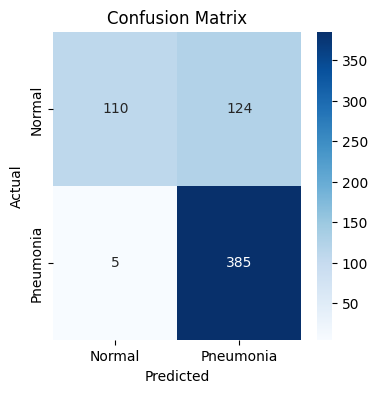

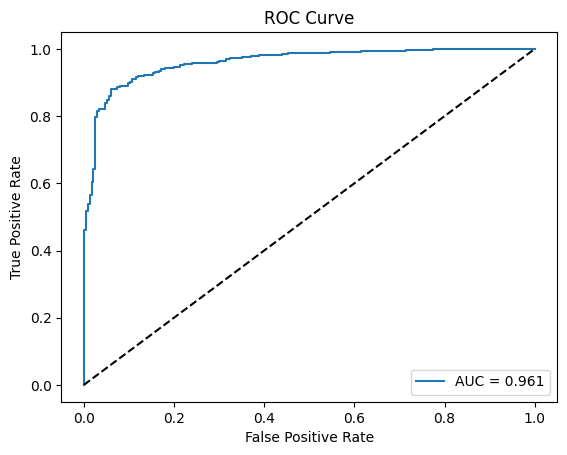

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# ---------- 1️⃣ Evaluate on test set ----------
y_true = []
y_pred = []
y_prob = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)
    y_prob.extend(probs[:, 0])
    y_pred.extend((probs[:, 0] > 0.5).astype(int))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

accuracy = (y_true == y_pred).mean()
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)        # recall
specificity = tn / (tn + fp)
roc_auc = roc_auc_score(y_true, y_prob)

print(f"Accuracy   : {accuracy:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"ROC-AUC    : {roc_auc:.3f}")
print("\nConfusion Matrix:\n", cm)

# ---------- 2️⃣ Confusion matrix heatmap ----------
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Pneumonia'],
            yticklabels=['Normal','Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ---------- 3️⃣ ROC Curve ----------
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



In [8]:
model.summary()   # check the first few layers


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,593,861 (90.00 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,100 (16.02 KB)

Using image: /kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1676_virus_2892.jpeg
img_batch type/shape/dtype: <class 'numpy.ndarray'> (1, 224, 224, 3) float32
img min/max: 0.0 255.0
Backbone layer found: resnet50
Using last conv layer: conv5_block3_out
grad_model built. Inputs: [<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor>] Outputs: [<KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, ragged=False, name=keras_tensor_174>, <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_182>]
conv_out shape: (1, 7, 7, 2048)
prediction shape: (1, 1) prediction value(s): [0.9932775]
grads shape: (1, 7, 7, 2048)
pooled_grads shape: (2048,)
heatmap shape: (7, 7) min/max: 0.0 0.9999943


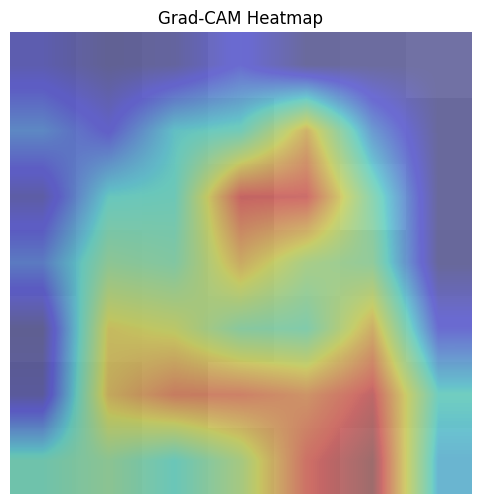

In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
import sys

# ---- 0. Helper: pick a sample path (adjust 'path' if different) ----
sample_list = glob(os.path.join(path, "chest_xray/test/*/*"))
if not sample_list:
    raise RuntimeError("No test images found at: " + os.path.join(path, "chest_xray/test"))
sample_path = sample_list[0]
print("Using image:", sample_path)

# ---- 1. Load image and prepare array ----
img = keras.utils.load_img(sample_path, target_size=(224,224))
img_array = keras.utils.img_to_array(img)    # shape (224,224,3), dtype=float32
img_batch = np.expand_dims(img_array, axis=0)  # (1,224,224,3)
print("img_batch type/shape/dtype:", type(img_batch), img_batch.shape, img_batch.dtype)
print("img min/max:", float(img_batch.min()), float(img_batch.max()))

# OPTIONAL: if you used rescale=1./255 during training, uncomment:
# img_batch = img_batch / 255.0

# ---- 2. Find the ResNet backbone inside the Sequential model ----
try:
    backbone = model.get_layer("resnet50")
except Exception as e:
    # fallback: search for layer with 'resnet' in name
    backbone = None
    for lyr in model.layers:
        if "resnet" in lyr.name.lower():
            backbone = lyr
            break
    if backbone is None:
        raise RuntimeError("ResNet backbone not found inside model. model.layers names:\n" +
                           "\n".join([l.name for l in model.layers]))

print("Backbone layer found:", backbone.name)

# ---- 3. Identify last conv layer name (conv5_block3_out is typical for ResNet50) ----
last_conv_name = "conv5_block3_out"
if last_conv_name not in [l.name for l in backbone.layers]:
    # try to find a conv layer near the end automatically
    cand = [l.name for l in backbone.layers if "conv5" in l.name or "conv" in l.name]
    # pick last conv-like layer
    last_conv_name = None
    for ln in reversed([l.name for l in backbone.layers]):
        if "conv" in ln:
            last_conv_name = ln
            break
    if last_conv_name is None:
        raise RuntimeError("Could not find a convolutional layer in backbone. Backbone layers:\n" +
                           "\n".join([l.name for l in backbone.layers]))
print("Using last conv layer:", last_conv_name)

# ---- 4. Build grad_model: backbone.input -> (last_conv.output, full_model_output) ----
last_conv_layer = backbone.get_layer(last_conv_name)

# Build the tail (apply model.layers[1:] to backbone.output) so we avoid Sequential wrapper issues
x = backbone.output
# apply rest of layers from the outer Sequential model to backbone.output
for idx, layer in enumerate(model.layers[1:], start=1):
    # Important: ensure layers that behave differently during training are used with training=False
    # (e.g., Dropout, BatchNormalization). Most layers accept a 'training' argument.
    try:
        if isinstance(layer, keras.layers.Dropout):
            x = layer(x, training=False)
        elif isinstance(layer, keras.layers.BatchNormalization):
            x = layer(x, training=False)
        else:
            x = layer(x)
    except TypeError:
        # some layers may not accept 'training' in that way; just call normally
        x = layer(x)
preds = x  # final predictions tensor

# Now construct grad_model
grad_model = keras.models.Model(inputs=backbone.input, outputs=[last_conv_layer.output, preds])
print("grad_model built. Inputs:", grad_model.inputs, "Outputs:", grad_model.outputs)

# ---- 5. Sanity forward pass to ensure nothing is None ----
img_tensor = tf.convert_to_tensor(img_batch, dtype=tf.float32)
# If you normalized during training, ensure same normalization here (uncomment if needed)
# img_tensor = img_tensor / 255.0

conv_out, prediction = grad_model(img_tensor)
print("conv_out shape:", conv_out.shape)
print("prediction shape:", prediction.shape, "prediction value(s):", prediction.numpy().ravel())

# ---- 6. Grad-CAM computation ----
with tf.GradientTape() as tape:
    tape.watch(conv_out)  # explicitly watch conv_out (not strictly necessary but safe)
    conv_out, preds = grad_model(img_tensor)
    top_class = preds[:, 0]  # pneumonia probability
grads = tape.gradient(top_class, conv_out)
if grads is None:
    raise RuntimeError("Gradient is None — something went wrong computing gradients. \
Make sure model is callable and tensors are valid.")
print("grads shape:", grads.shape)

# global average pooling of gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
print("pooled_grads shape:", pooled_grads.shape)

# compute the weighted sum of conv feature maps
conv_out_0 = conv_out[0]   # (h, w, c)
heatmap = tf.reduce_sum(tf.multiply(conv_out_0, pooled_grads), axis=-1)
heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
heatmap = heatmap.numpy()
print("heatmap shape:", heatmap.shape, "min/max:", heatmap.min(), heatmap.max())

# ---- 7. Display overlay ----
plt.figure(figsize=(6,6))
plt.imshow(keras.utils.array_to_img(img_batch[0].astype("uint8")))
plt.imshow(heatmap, cmap='jet', alpha=0.4, interpolation='bilinear')
plt.axis('off')
plt.title("Grad-CAM Heatmap")
plt.show()
